In [120]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import statsmodels.formula.api as smf
import datetime as dt

from Package.PlotHandler import *

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 설정
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
raw_data_df = pd.read_excel('Data/데이터 취합(240528).xlsx')

In [3]:
tidy_data = raw_data_df.dropna()
tidy_data.set_index('date', inplace=True)

In [4]:
# TODO: 신고저가로 Net 비율 구하기 --> Stock Price Strength(5거래일 rolling sum 해서 비율 산출)
# TODO: 상승/하락 종목 수로 McClellan Volume Summation Index 만들기(자료 참조, Mcclellan Volume Summation Index 파일 참조)
# 미국 변수들과 1일 래깅 맞춰 주기
# tidy_data

In [5]:
tidy_data.columns

Index(['코스피 지수', '코스피 상승종목수', '코스피 하락종목수', '국고채권(3년)', '회사채(무보증3년)AA-',
       '회사채(무보증3년)BBB-', '국고채권(10년)', '뉴스심리지수(일간)', '원/달러(종가)', '코스피 신고가 종목수',
       '코스피 신저가 종목수', 'KRX 신고가 종목', 'KRX 신저가 종목', '거래량 Put', '거래량 Call',
       '일별 Put Call ratio', 'VKOSPI', 'US Gov 10Yr', '미국채 10년 이자율',
       '한국 국채 10년 이자율', '한국 CDS Spread', '코스피 거래종목 수 ', '코스닥 거래종목 수'],
      dtype='object')

In [6]:
# KOSPI 가격 수준 지표
kospi_rolling_window = 125

kospi_index_df = tidy_data[['코스피 지수']].copy()
kospi_index_df['코스피 125MA'] = kospi_index_df.rolling(window=125).mean()
kospi_index_df['kospi_deviation'] = kospi_index_df['코스피 지수'] - kospi_index_df['코스피 125MA']

In [7]:
# 신고저가 종목 Net 52 high_low(구성종목수 추가)
krx_highlow_window = 125

krx_52highlow_df = tidy_data[['KRX 신고가 종목', 'KRX 신저가 종목', '코스피 거래종목 수 ', '코스닥 거래종목 수']].copy()
krx_52highlow_5days_df = krx_52highlow_df.rolling(window=50).sum()
krx_52highlow_5days_df['net_high_low_ratio'] = (
    (krx_52highlow_5days_df.iloc[:,0] - krx_52highlow_5days_df.iloc[:,1])/
        (krx_52highlow_5days_df.iloc[:,2]+krx_52highlow_5days_df.iloc[:,3])
    )

In [8]:
# Put, Call ratio 5일 계산
put_call_ratio_window = 5
put_call_ratio_df = tidy_data[['거래량 Put', '거래량 Call']].copy()
put_call_ratio_df['put/call ratio'] = put_call_ratio_df['거래량 Put']/ put_call_ratio_df['거래량 Call']
put_call_5d_sum = put_call_ratio_df.rolling(window=put_call_ratio_window).mean()

In [9]:
# VKOSPI 50일 이동 평균 Deviation
vkospi_window = 50
vkospi_df = tidy_data[['VKOSPI']].copy()
vkospi_df['50ma'] = vkospi_df.rolling(window=vkospi_window).mean()
vkospi_df['vkospi_deviance'] = vkospi_df['VKOSPI'] - vkospi_df['50ma']

In [10]:
# 회사채 Spread(Junk bond Spread)
junk_bond_spread_df = tidy_data[['국고채권(3년)','회사채(무보증3년)AA-', '회사채(무보증3년)BBB-']].copy()
junk_bond_spread_df['junkbond_spread'] = -junk_bond_spread_df['회사채(무보증3년)AA-']  +junk_bond_spread_df['회사채(무보증3년)BBB-']
junk_bond_spread_df['credit_spread'] = -junk_bond_spread_df['국고채권(3년)']  +junk_bond_spread_df['회사채(무보증3년)AA-']

In [11]:
# 채권, 주식 수익률(1개월, 3개월,6개월, 12개월 각각 계산 등, CNN에서는 20일 수익률 사용)
safe_haven_window = 20
safe_haven_demand_df = tidy_data[['코스피 지수', '국고채권(10년)']].copy()
safe_haven_demand_df['코스피 20일 수익률'] = safe_haven_demand_df['코스피 지수'].pct_change(periods=safe_haven_window)
safe_haven_demand_df['채권 20일 수익률'] = np.nan
for i in range(20, len(safe_haven_demand_df)):
    r_t_1 = safe_haven_demand_df.iloc[i- safe_haven_window + 1,1]
    r_t = safe_haven_demand_df.iloc[i,1]
    bond_return = r_t_1/r_t + r_t_1/1200 + ((1+r_t/1200)**(-119) * (1- r_t_1/r_t))
    safe_haven_demand_df.iloc[i, 3] = bond_return-1
safe_haven_demand_df['safe_haven_return'] = safe_haven_demand_df['코스피 20일 수익률'] - safe_haven_demand_df['채권 20일 수익률']


In [12]:
# 상승, 하락 종목수 Sentiment
mcclellan_df = tidy_data[['코스피 상승종목수', '코스피 하락종목수']].copy()
mcclellan_df['net advance'] = mcclellan_df['코스피 상승종목수'] - mcclellan_df['코스피 하락종목수']
mcclellan_df['ratio_adjusted'] = mcclellan_df['net advance']/(mcclellan_df['코스피 상승종목수'] + mcclellan_df['코스피 하락종목수'])*1000

# 19일 EMA 계산
mcclellan_df['19_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=50, adjust=False).mean()

# 39일 EMA 계산
mcclellan_df['39_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=125, adjust=False).mean()

# 19일 EMA와 39일 EMA의 차이 계산
mcclellan_df['EMA_diff'] = mcclellan_df['19_day_EMA'] - mcclellan_df['39_day_EMA']

mcclellan_df

,코스피 상승종목수,코스피 하락종목수,net advance,ratio_adjusted,19_day_EMA,39_day_EMA,EMA_diff
date,,,,,,,
2008-01-02,283.0,535.0,-252.0,-308.068460,-308.068460,-308.068460,0.000000
2008-01-03,345.0,451.0,-106.0,-133.165829,-301.209533,-305.292227,4.082694
2008-01-04,401.0,385.0,16.0,20.356234,-288.599111,-300.123204,11.524093
2008-01-07,221.0,589.0,-368.0,-454.320988,-295.098008,-302.570788,7.472780
2008-01-08,347.0,445.0,-98.0,-123.737374,-288.377983,-299.732162,11.354179
...,...,...,...,...,...,...,...
2024-05-21,292.0,588.0,-296.0,-336.363636,-35.917389,-50.520097,14.602708
2024-05-22,402.0,478.0,-76.0,-86.363636,-37.895673,-51.089042,13.193369
2024-05-23,349.0,534.0,-185.0,-209.513024,-44.625765,-53.603708,8.977943


<Axes: >

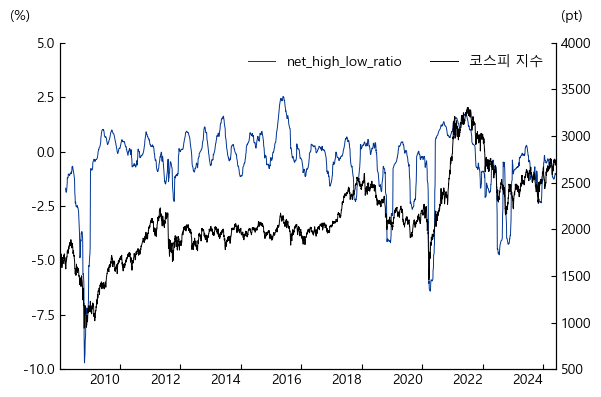

In [13]:
plot_data_df = pd.DataFrame([krx_52highlow_5days_df.net_high_low_ratio*100, kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(%)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

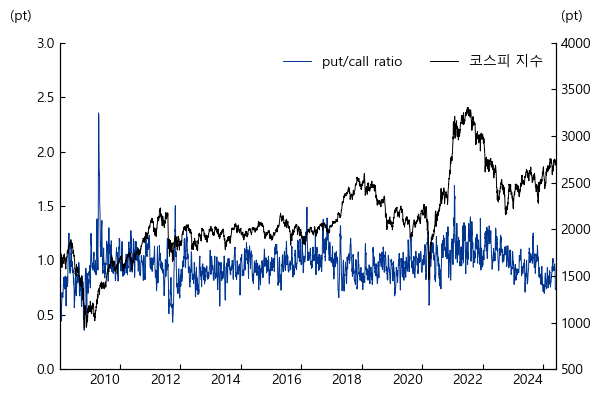

In [14]:
plot_data_df = pd.DataFrame([put_call_5d_sum['put/call ratio'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)



<Axes: >

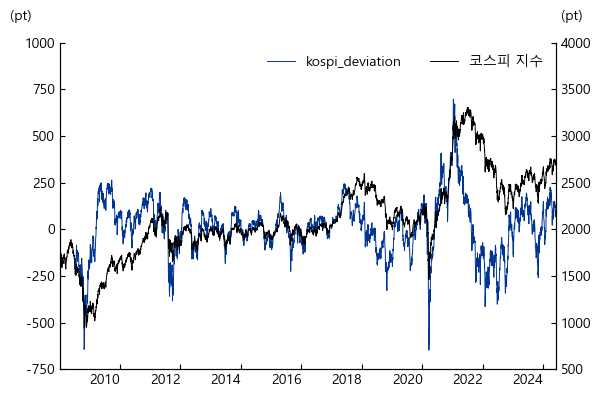

In [15]:
plot_data_df = pd.DataFrame([kospi_index_df['kospi_deviation'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

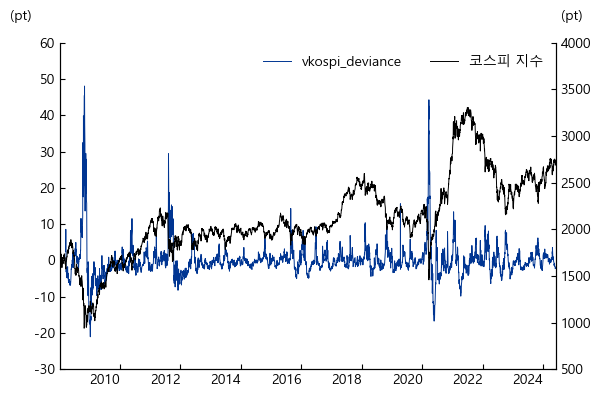

In [16]:
plot_data_df = pd.DataFrame([vkospi_df['vkospi_deviance'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

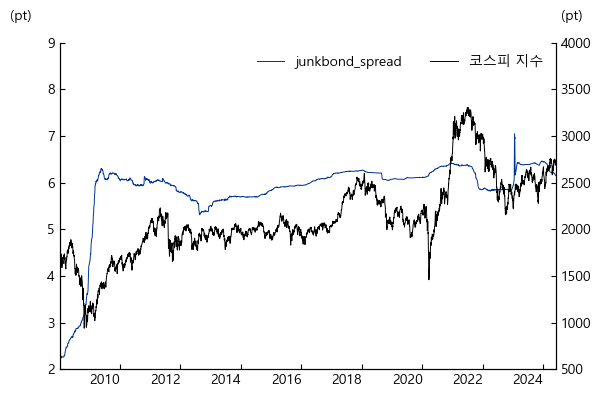

In [17]:
plot_data_df = pd.DataFrame([junk_bond_spread_df['junkbond_spread'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

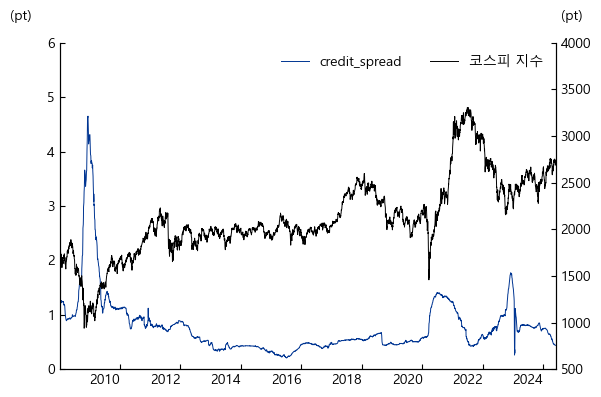

In [18]:
plot_data_df = pd.DataFrame([junk_bond_spread_df['credit_spread'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)



<Axes: >

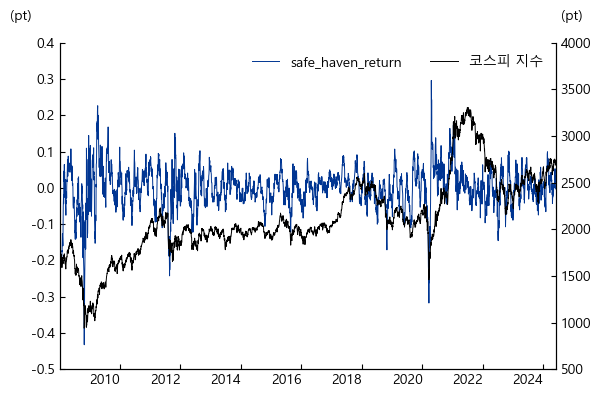

In [19]:
plot_data_df = pd.DataFrame([safe_haven_demand_df['safe_haven_return'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)



date
2008-01-02         NaN
2008-01-03         NaN
2008-01-04         NaN
2008-01-07         NaN
2008-01-08         NaN
                ...   
2024-05-21   -1.057287
2024-05-22   -1.002850
2024-05-23   -1.002157
2024-05-24   -1.019351
2024-05-27   -1.033441
Name: net_high_low_ratio, Length: 4052, dtype: float64

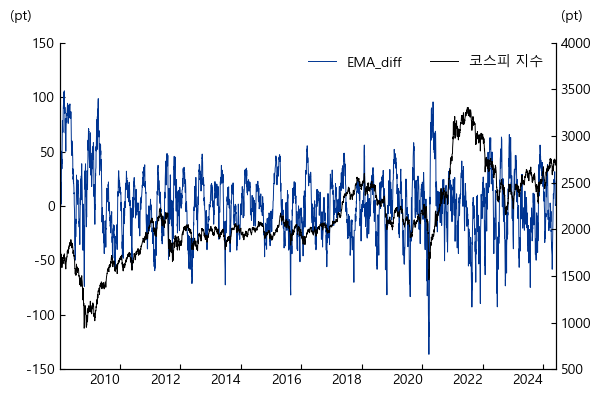

In [20]:
plot_data_df = pd.DataFrame([mcclellan_df['EMA_diff'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)
krx_52highlow_5days_df.net_high_low_ratio*100


<Axes: >

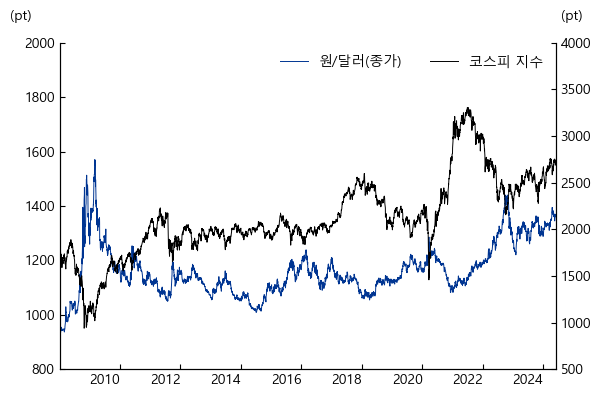

In [21]:
plot_data_df = pd.DataFrame([tidy_data['원/달러(종가)'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

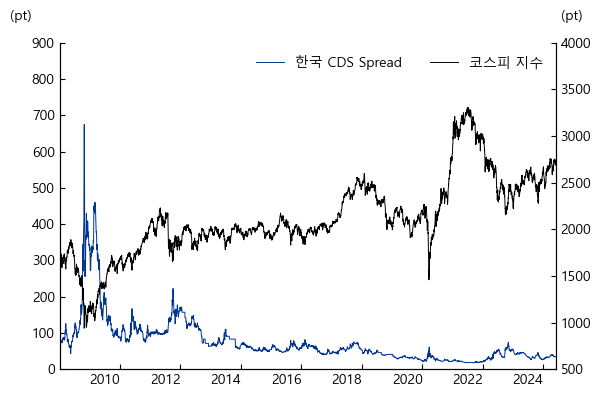

In [22]:
plot_data_df = pd.DataFrame([tidy_data['한국 CDS Spread'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

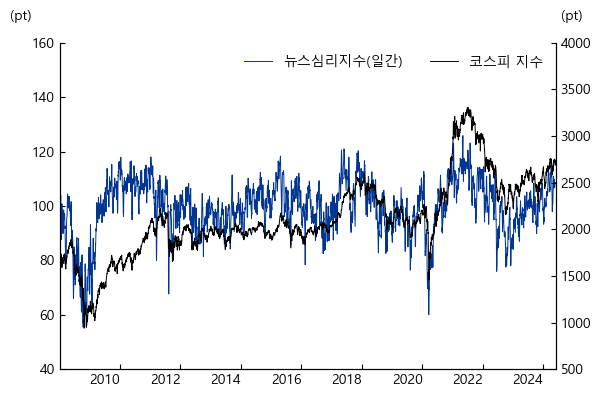

In [23]:
plot_data_df = pd.DataFrame([tidy_data['뉴스심리지수(일간)'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)



<Axes: >

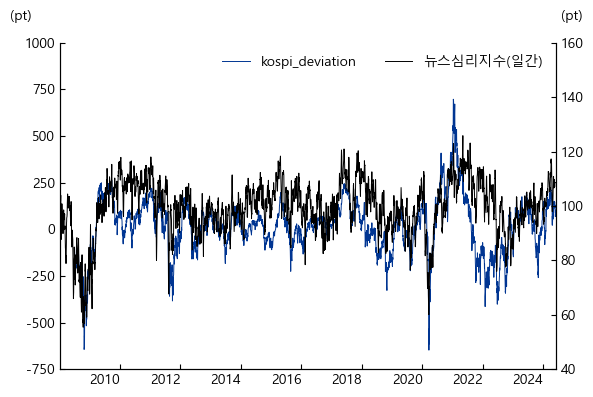

In [24]:
plot_data_df = pd.DataFrame([kospi_index_df['kospi_deviation'], tidy_data['뉴스심리지수(일간)']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

In [25]:
data_name_list = ['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread', 'credit_spread', 'safe_haven_return', 'EMA_diff',
                  'USD/KRW', 'KR_CDS_spread']
whole_data_df = pd.DataFrame([
        put_call_5d_sum['put/call ratio'],
        kospi_index_df['kospi_deviation'],
        vkospi_df['vkospi_deviance'],
        junk_bond_spread_df['junkbond_spread'],
        junk_bond_spread_df['credit_spread'],
        safe_haven_demand_df['safe_haven_return'],
        mcclellan_df['EMA_diff'],
        tidy_data['원/달러(종가)'],
        tidy_data['한국 CDS Spread'],
    ], index = data_name_list)

whole_data_df = whole_data_df.T

In [26]:
def rolling_standardize(series, window):
    """주어진 시리즈에 대해 윈도우 크기를 사용하여 표준화합니다."""
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std()
    standardized_series = (series - rolling_mean) / rolling_std
    return standardized_series

# 각 열에 대한 윈도우 크기를 정의합니다
window_sizes = {
    'PC_ratio': 504,
    'KOSPI_dev': 125,
    'VKOSPI_dev': 50,
    'junkbond_spread': 50,
    'credit_spread': 50,
    'safe_haven_return': 50,
    'EMA_diff': 504,
    'USD/KRW': 50,
    'KR_CDS_spread': 50
}

minus_sign = {
    'PC_ratio': True,
    'KOSPI_dev': False,
    'VKOSPI_dev': True,
    'junkbond_spread': True,
    'credit_spread': True,
    'safe_haven_return': False,
    'EMA_diff': False,
    'USD/KRW': True,
    'KR_CDS_spread': True
}

# 각 열에 대해 표준화를 수행합니다
standardized_df = pd.DataFrame(index=whole_data_df.index)

for column, window in window_sizes.items():
    if minus_sign[column]:
        standardized_df[column] = rolling_standardize(-whole_data_df[column], window)
    else:
        standardized_df[column] = rolling_standardize(whole_data_df[column], window)

mean_values = standardized_df.T.mean().T * 50 + 50 

def normalize_series(series, window=125):
    rolling_min = series.rolling(window=window, min_periods=1).min()
    rolling_max = series.rolling(window=window, min_periods=1).max()
    normalized_series = (series - rolling_min) / (rolling_max - rolling_min)
    return normalized_series

normalized_mean_values = normalize_series(mean_values) *100

<Axes: >

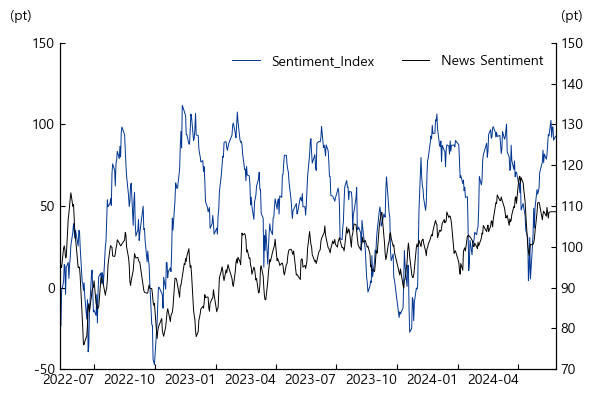

In [27]:
last_plot_n = 504
plot_data_df = pd.DataFrame([mean_values[-last_plot_n:], tidy_data['뉴스심리지수(일간)'][-last_plot_n:]], index=['Sentiment_Index', 'News Sentiment']).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

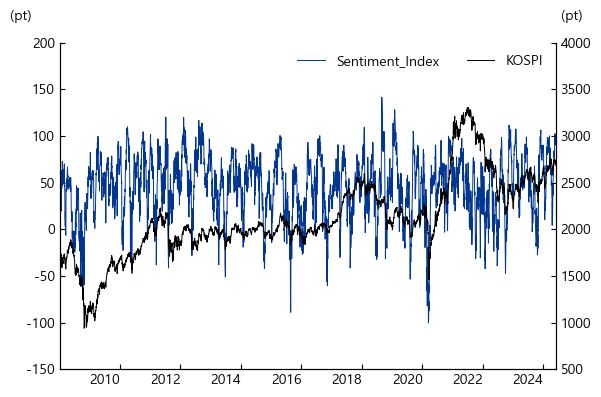

In [28]:
last_plot_n = 5000
plot_data_df = pd.DataFrame([mean_values[-last_plot_n:], kospi_index_df['코스피 지수'][-last_plot_n:]], index=['Sentiment_Index', 'KOSPI']).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

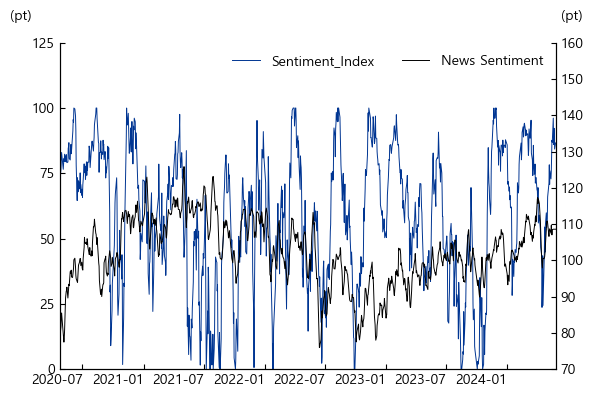

In [29]:
last_plot_n = 1008
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], tidy_data['뉴스심리지수(일간)'][-last_plot_n:]], index=['Sentiment_Index', 'News Sentiment']).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

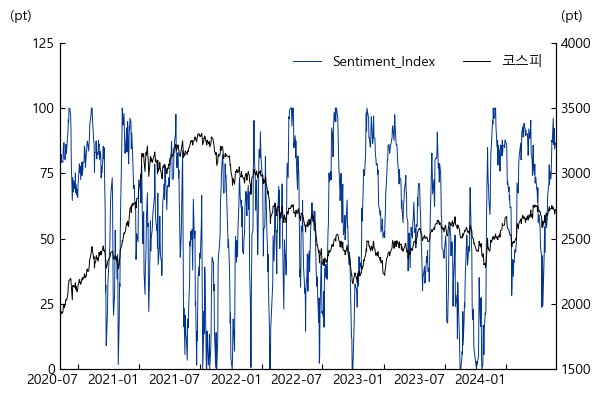

In [30]:
last_plot_n = 1000
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], kospi_index_df['코스피 지수'][-last_plot_n:]], index=['Sentiment_Index', '코스피']).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

In [150]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 30,
    'G': 10,
    'N': -10,
    'F': -30,
    'EF': -50
}

# Parameter
window_size = 20
lag = 0
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return *100, sentiment_index-50], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if x < (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if x < (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if x < (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':20})
# reg = smf.ols('a ~ 1 + b + ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':20})
# reg = smf.ols('a ~ 1 + ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.1518
Date:                Tue, 04 Jun 2024   Prob (F-statistic):              0.697
Time:                        17:59:11   Log-Likelihood:                -10459.
No. Observations:                3531   AIC:                         2.092e+04
Df Residuals:                    3529   BIC:                         2.093e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4132      0.312      1.326      0.1

<Axes: >

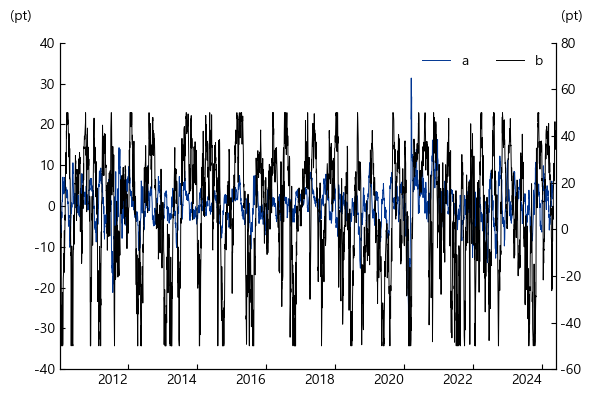

In [151]:
last_plot_n = 1000
plot_data_df = df[['a','b']].copy()
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

In [152]:
## TODO: 그림상으로 봤을 때 낮은 구간이랑 높은 구간이랑 차이가 있음
## (낮은 구간에서는 저가매수, 높은 구간에서는 모멘텀으로 더 올라가는 경우가 발생함)